# Prediction of prices in Beijing
* url: https://www.kaggle.com/datasets/ruiqurm/lianjia

# Import all the libraries

In [1]:
import random
import pandas as pd
pd.set_option('display.max_columns', None) # Show all the columns of the DataFrame.
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.tree import DecisionTreeRegressor

## Data path

In [2]:
main_path = "/home/andres/Proyectos/Python/Machine Learning/Housing price Beijing"
file_name = "housing_beijing.csv"
path = os.path.join(main_path, file_name)

#### Columns of the dataset
* url: the url which fetches the data
* id: the id of transaction
* Lng: and Lat coordinates, using the BD09 protocol.
* Cid: community id
* tradeTime: the time of transaction
* DOM: active days on market.Know more in https://en.wikipedia.org/wiki/Days_on_market
* followers: the number of people follow the transaction.
* totalPrice: the total price
* price: the average price by square
* square: the square of house
* livingRoom: the number of living room
* drawingRoom: the number of drawing room
* kitchen: the number of kitchen
* bathroom the number of bathroom
* floor: the height of the house.
* buildingType: including tower( 1 ) , bungalow( 2 )，combination of plate and tower( 3 ), plate( 4 ).
* constructionTime: the time of construction
* renovationCondition: including other( 1 ), rough( 2 ),Simplicity( 3 ), hardcover( 4 )
* buildingStructure: including unknow( 1 ), mixed( 2 ), brick and wood( 3 ), brick and concrete( 4 ),steel( 5 ) and steel-concrete composite ( 6 ).
* ladderRatio: the proportion between number of residents on the same floor and number of elevator of ladder. It describes how many ladders a resident have on average.
* elevator have ( 1 ) or not have elevator( 0 )
* fiveYearsProperty: if the owner have the property for less than 5 years.

Most data is traded in 2011-2017, some of them is traded in Jan,2018, and some is even earlier(2010,2009)

All the data was fetching from https://bj.lianjia.com/chengjiao. 

Some columns are missing a description.


## Exploratory analysis of the dataset

In [3]:
# dtype = str: We make all columns str to avoid problems loading the data.
# low_memory = False: If there are missing values or mixed data types, it may require more memory for type inference.
# encoding = 'gbk': To read chinesse characters.
data = pd.read_csv(path, encoding = 'gbk', dtype = str, low_memory = False)
data.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.01952,1111027376244,2016-08-09,1464,106,415.0,31680,131.0,2,1,1,1,高 26,1,2005,3,6,0.217,1.0,0.0,1.0,7,56021
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903,126,575.0,43436,132.38,2,2,1,2,高 22,1,2004,4,6,0.667,1.0,1.0,0.0,7,71539
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271,48,1030.0,52021,198.0,3,2,1,3,中 4,4,2005,3,6,0.5,1.0,0.0,0.0,7,48160
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.43801,40.076114,1111043185817,2016-09-30,965,138,297.5,22202,134.0,3,1,1,1,底 21,1,2008,1,6,0.273,1.0,0.0,0.0,6,51238
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927,286,392.0,48396,81.0,2,1,1,1,中 6,4,1960,2,2,0.333,0.0,1.0,1.0,1,62588


In [4]:
data.shape

(318851, 26)

In [5]:
data.dtypes

url                    object
id                     object
Lng                    object
Lat                    object
Cid                    object
tradeTime              object
DOM                    object
followers              object
totalPrice             object
price                  object
square                 object
livingRoom             object
drawingRoom            object
kitchen                object
bathRoom               object
floor                  object
buildingType           object
constructionTime       object
renovationCondition    object
buildingStructure      object
ladderRatio            object
elevator               object
fiveYearsProperty      object
subway                 object
district               object
communityAverage       object
dtype: object

The dataset has one problem, the column 'totalPrice' which correspond to the total price is lesser than the 'price'
column, which is the price per square. The reason for this is because the 'totalPrice' column does not have all the
digits, so we are goint to drop the column and create a new 'Price' column multiplying the 'price' columun with the
'square' column, we are going to do the following steps:
* Drop the 'totalPrice' column.
* Convert the 'price' and 'square' columns data type to float (right now they are objects).

In [6]:
# Step 1
data = data.drop('totalPrice', axis = 1)
data.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,price,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.01952,1111027376244,2016-08-09,1464,106,31680,131.0,2,1,1,1,高 26,1,2005,3,6,0.217,1.0,0.0,1.0,7,56021
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903,126,43436,132.38,2,2,1,2,高 22,1,2004,4,6,0.667,1.0,1.0,0.0,7,71539
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271,48,52021,198.0,3,2,1,3,中 4,4,2005,3,6,0.5,1.0,0.0,0.0,7,48160
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.43801,40.076114,1111043185817,2016-09-30,965,138,22202,134.0,3,1,1,1,底 21,1,2008,1,6,0.273,1.0,0.0,0.0,6,51238
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927,286,48396,81.0,2,1,1,1,中 6,4,1960,2,2,0.333,0.0,1.0,1.0,1,62588


In [7]:
data.shape

(318851, 25)

In [8]:
# Step 2
data['price'] = data['price'].astype(float)
data['square'] = data['square'].astype(float)
data.dtypes

url                     object
id                      object
Lng                     object
Lat                     object
Cid                     object
tradeTime               object
DOM                     object
followers               object
price                  float64
square                 float64
livingRoom              object
drawingRoom             object
kitchen                 object
bathRoom                object
floor                   object
buildingType            object
constructionTime        object
renovationCondition     object
buildingStructure       object
ladderRatio             object
elevator                object
fiveYearsProperty       object
subway                  object
district                object
communityAverage        object
dtype: object

In [9]:
# Step 3
data['Price'] = data['price'] * data['square']
data.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,price,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,Price
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.01952,1111027376244,2016-08-09,1464,106,31680.0,131.00,2,1,1,1,高 26,1,2005,3,6,0.217,1.0,0.0,1.0,7,56021,4150080.00
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903,126,43436.0,132.38,2,2,1,2,高 22,1,2004,4,6,0.667,1.0,1.0,0.0,7,71539,5750057.68
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271,48,52021.0,198.00,3,2,1,3,中 4,4,2005,3,6,0.5,1.0,0.0,0.0,7,48160,10300158.00
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.43801,40.076114,1111043185817,2016-09-30,965,138,22202.0,134.00,3,1,1,1,底 21,1,2008,1,6,0.273,1.0,0.0,0.0,6,51238,2975068.00
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927,286,48396.0,81.00,2,1,1,1,中 6,4,1960,2,2,0.333,0.0,1.0,1.0,1,62588,3920076.00


### Create a subset with the desired columns
Not all the columns are useful, we are going to stay with all the columns that bring some value.

In [10]:
columns = data.columns.values.tolist()
columns

['url',
 'id',
 'Lng',
 'Lat',
 'Cid',
 'tradeTime',
 'DOM',
 'followers',
 'price',
 'square',
 'livingRoom',
 'drawingRoom',
 'kitchen',
 'bathRoom',
 'floor',
 'buildingType',
 'constructionTime',
 'renovationCondition',
 'buildingStructure',
 'ladderRatio',
 'elevator',
 'fiveYearsProperty',
 'subway',
 'district',
 'communityAverage',
 'Price']

In [11]:
# Create the desired subset
columns_set = set(columns)
columns_subset = {'url', 'Cid', 'id', 'price'}
desired_columns = columns_set - columns_subset
desired_columns = list(desired_columns)
desired_columns

['buildingType',
 'renovationCondition',
 'ladderRatio',
 'tradeTime',
 'Lng',
 'subway',
 'communityAverage',
 'drawingRoom',
 'district',
 'constructionTime',
 'fiveYearsProperty',
 'Price',
 'floor',
 'bathRoom',
 'followers',
 'Lat',
 'square',
 'elevator',
 'kitchen',
 'livingRoom',
 'DOM',
 'buildingStructure']

In [12]:
# Create a new DataFrame using the desired columns
desired_data = data[desired_columns]
desired_data.head()

,buildingType,renovationCondition,ladderRatio,tradeTime,Lng,subway,communityAverage,drawingRoom,district,constructionTime,fiveYearsProperty,Price,floor,bathRoom,followers,Lat,square,elevator,kitchen,livingRoom,DOM,buildingStructure
0,1,3,0.217,2016-08-09,116.475489,1.0,56021,1,7,2005,0.0,4150080.00,高 26,1,106,40.01952,131.00,1.0,1,2,1464,6
1,1,4,0.667,2016-07-28,116.453917,0.0,71539,2,7,2004,1.0,5750057.68,高 22,2,126,39.881534,132.38,1.0,1,2,903,6
2,4,3,0.5,2016-12-11,116.561978,0.0,48160,2,7,2005,0.0,10300158.00,中 4,3,48,39.877145,198.00,1.0,1,3,1271,6
3,1,1,0.273,2016-09-30,116.43801,0.0,51238,1,6,2008,0.0,2975068.00,底 21,1,138,40.076114,134.00,1.0,1,3,965,6
4,4,2,0.333,2016-08-28,116.428392,1.0,62588,1,1,1960,1.0,3920076.00,中 6,1,286,39.886229,81.00,0.0,1,2,927,2


### Renaming the columns

In [13]:
desired_data = desired_data.rename(columns = {'ladderRatio': 'Ladder Ratio', 'communityAverage': 'Community Average',
                                  'fiveYearsProperty': 'Five Years Property', 'square': 'Square',  
                                  'livingRoom': 'Living Room', 'bathRoom': 'Bathroom', 'kitchen': 'Kitchen',
                                   'buildingType': 'Building Type', 'buildingStructure': 'Building Structure',
                                  'elevator': 'Elevator', 'constructionTime': 'Construction Time', 
                                  'renovationCondition': 'Renovation Condition', 'subway': 'Subway',
                                    'drawingRoom': 'Drawing Room', 'floor': 'Floor', 'district': 'District',
                                    'tradeTime': 'Trade Time', 'followers': 'Followers'})
desired_data.head()

,Building Type,Renovation Condition,Ladder Ratio,Trade Time,Lng,Subway,Community Average,Drawing Room,District,Construction Time,Five Years Property,Price,Floor,Bathroom,Followers,Lat,Square,Elevator,Kitchen,Living Room,DOM,Building Structure
0,1,3,0.217,2016-08-09,116.475489,1.0,56021,1,7,2005,0.0,4150080.00,高 26,1,106,40.01952,131.00,1.0,1,2,1464,6
1,1,4,0.667,2016-07-28,116.453917,0.0,71539,2,7,2004,1.0,5750057.68,高 22,2,126,39.881534,132.38,1.0,1,2,903,6
2,4,3,0.5,2016-12-11,116.561978,0.0,48160,2,7,2005,0.0,10300158.00,中 4,3,48,39.877145,198.00,1.0,1,3,1271,6
3,1,1,0.273,2016-09-30,116.43801,0.0,51238,1,6,2008,0.0,2975068.00,底 21,1,138,40.076114,134.00,1.0,1,3,965,6
4,4,2,0.333,2016-08-28,116.428392,1.0,62588,1,1,1960,1.0,3920076.00,中 6,1,286,39.886229,81.00,0.0,1,2,927,2


### Numeric conversion

In [14]:
def NumericConversion(df):
    results = {}
    for column in df.columns:
        try:
            # Numeric conversion
            df[column] = pd.to_numeric(df[column])
            print(f"The column '{column}' has been successfully converted to numeric.")
        except ValueError:
            # Calculate unique values with their absolute and relative frequency
            unique_values = df[column].unique()
            frequency = df[column].value_counts()
            relative_frequency = df[column].value_counts(normalize = True) * 100
            results[column] = {
                'unique_values': unique_values,
                'frequency': frequency.to_dict(),
                'relative_frequency': relative_frequency.round(2).to_dict()
            }
    return print(results)

In [15]:
NumericConversion(desired_data)

The column 'Building Type' has been successfully converted to numeric.
The column 'Renovation Condition' has been successfully converted to numeric.
The column 'Ladder Ratio' has been successfully converted to numeric.
The column 'Lng' has been successfully converted to numeric.
The column 'Subway' has been successfully converted to numeric.
The column 'Community Average' has been successfully converted to numeric.
The column 'District' has been successfully converted to numeric.
The column 'Five Years Property' has been successfully converted to numeric.
The column 'Price' has been successfully converted to numeric.
The column 'Followers' has been successfully converted to numeric.
The column 'Lat' has been successfully converted to numeric.
The column 'Square' has been successfully converted to numeric.
The column 'Elevator' has been successfully converted to numeric.
The column 'Kitchen' has been successfully converted to numeric.
The column 'DOM' has been successfully converted to 

From the above data we can see that the 'Floor' column has combined data (kanji + number), so we are going to translate the kanjus to english.
The other columns have too little rows with combined data, so we can drop them as well the rows with wrong data, for exmple, Construcion Time has two non sense values, "1" and "0", Living Room has the "#NAME?" value.
Construction Time has about 6% of the rows with the value "未知", so we are going to drop those rows and lose 6% of the data.

In [16]:
desired_data = desired_data[(desired_data['Construction Time'] != '未知') & 
                            (desired_data['Construction Time'] != '1') & 
                            (desired_data['Construction Time'] != '0')]

desired_data = desired_data[desired_data['Bathroom'] != '未知']
desired_data['Bathroom'] = pd.to_numeric(desired_data['Bathroom'])
desired_data = desired_data[desired_data['Bathroom'] <= 7]

desired_data = desired_data[desired_data['Bathroom'] != '#NAME?']

desired_data = desired_data[pd.to_numeric(desired_data['Drawing Room'], errors = 'coerce').notna()]

# We extract the year of the Trade Time column
desired_data['Trade Time'] = pd.DatetimeIndex(desired_data['Trade Time']).year

numeric_list = []
kanji_list = []
for value in desired_data['Floor'].values:
    # We split the row value into a numeric part and a str (kanji) part
    parts = value.split(maxsplit = 1) # Limit to one division in case there are multiple blank spaces
    try:
        kanji = parts[0]
        numeric = parts[1]
    except:
        kanji = np.nan
        numeric = np.nan
    numeric_list.append(numeric)
    kanji_list.append(kanji)

# Go to https://jisho.org/ to look for the kanji meanings
kanji_dictionary = {
    '中':'Middle',
    '高':'High',
    '底':'Bottom',
    '低':'Low',
    '顶':'Top',
    '未知':'Unknown'
}
english_meanings = [kanji_dictionary.get(kanji) for kanji in kanji_list]

df1 = pd.DataFrame(english_meanings,columns = ['Floor Type'])
df2 = pd.DataFrame(numeric_list,columns = ['Floor Height'])
desired_data = pd.concat([desired_data, df1, df2], axis = 1)

desired_data = desired_data[desired_data['Floor Type'] != 'Unknown']
desired_data = desired_data.drop('Floor', axis = 1)

In [17]:
NumericConversion(desired_data)

The column 'Building Type' has been successfully converted to numeric.
The column 'Renovation Condition' has been successfully converted to numeric.
The column 'Ladder Ratio' has been successfully converted to numeric.
The column 'Trade Time' has been successfully converted to numeric.
The column 'Lng' has been successfully converted to numeric.
The column 'Subway' has been successfully converted to numeric.
The column 'Community Average' has been successfully converted to numeric.
The column 'Drawing Room' has been successfully converted to numeric.
The column 'District' has been successfully converted to numeric.
The column 'Construction Time' has been successfully converted to numeric.
The column 'Five Years Property' has been successfully converted to numeric.
The column 'Price' has been successfully converted to numeric.
The column 'Bathroom' has been successfully converted to numeric.
The column 'Followers' has been successfully converted to numeric.
The column 'Lat' has been suc

### NaN values
Let's see how many rows with NaN values there are in the dataset.

In [18]:
data_copy = desired_data.copy() # Create a copy of the dataset.
data_copy = data_copy.dropna() # Drop NaN rows.
nan_rows = desired_data.shape[0] - data_copy.shape[0]
nan_rows

170533

In [19]:
(nan_rows / desired_data.shape[0]) * 100 # Porcentage of NaN rows.

53.91665876252806

The above analysis show us that more than half of the registers have at least one NaN in a column.

In [20]:
nans = desired_data.isna().sum()
nans

Building Type            19215
Renovation Condition     17671
Ladder Ratio             17671
Trade Time               17671
Lng                      17671
Subway                   17671
Community Average        17966
Drawing Room             17671
District                 17671
Construction Time        17671
Five Years Property      17671
Price                    17671
Bathroom                 17671
Followers                17671
Lat                      17671
Square                   17671
Elevator                 17671
Kitchen                  17671
Living Room              17671
DOM                     163201
Building Structure       17671
Floor Type               17745
Floor Height             17745
dtype: int64

We can see that most of the nans correspond to the DOM column, so we are going to drop it.

In [21]:
desired_data = desired_data.drop('DOM', axis = 1)
desired_data = desired_data.dropna()
nans = desired_data.isna().sum()
nans

Building Type           0
Renovation Condition    0
Ladder Ratio            0
Trade Time              0
Lng                     0
Subway                  0
Community Average       0
Drawing Room            0
District                0
Construction Time       0
Five Years Property     0
Price                   0
Bathroom                0
Followers               0
Lat                     0
Square                  0
Elevator                0
Kitchen                 0
Living Room             0
Building Structure      0
Floor Type              0
Floor Height            0
dtype: int64

In [22]:
desired_data.describe()

,Building Type,Renovation Condition,Ladder Ratio,Trade Time,Lng,Subway,Community Average,Drawing Room,District,Construction Time,Five Years Property,Price,Bathroom,Followers,Lat,Square,Elevator,Kitchen,Living Room,Building Structure,Floor Height
count,279137.000000,279137.000000,2.791370e+05,279137.000000,279137.000000,279137.000000,279137.000000,279137.000000,279137.000000,279137.000000,279137.000000,2.791370e+05,279137.000000,279137.000000,279137.000000,279137.000000,279137.000000,279137.000000,279137.000000,279137.000000,279137.000000
mean,3.035488,2.608823,7.210195e+01,2014.815116,116.421219,0.594160,61554.268750,1.179786,6.577921,1999.518932,0.642333,3.465571e+06,1.188219,17.596567,39.952402,83.494457,0.574549,0.994798,2.017669,4.451097,13.143643
std,1.260751,1.312382,2.679252e+04,1.694446,0.113646,0.491055,20157.942321,0.515280,2.776394,8.537196,0.479314,2.249978e+06,0.428037,35.564900,0.093039,35.809115,0.494412,0.102810,0.764746,1.901930,7.770097
min,1.000000,1.000000,1.400000e-02,2002.000000,116.072514,0.000000,10847.000000,0.000000,1.000000,1950.000000,0.000000,1.500000e+01,0.000000,0.000000,39.627030,7.800000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.000000,1.000000,2.500000e-01,2013.000000,116.344557,0.000000,46049.000000,1.000000,6.000000,1994.000000,0.000000,2.030013e+06,1.000000,0.000000,39.894213,58.400000,0.000000,1.000000,2.000000,2.000000,6.000000
50%,4.000000,3.000000,3.330000e-01,2015.000000,116.421749,1.000000,57942.000000,1.000000,7.000000,2002.000000,1.000000,2.900041e+06,1.000000,5.000000,39.936388,75.050000,1.000000,1.000000,2.000000,6.000000,11.000000
75%,4.000000,4.000000,5.000000e-01,2016.000000,116.480972,1.000000,72315.000000,1.000000,8.000000,2006.000000,1.000000,4.235034e+06,1.000000,19.000000,40.009521,99.090000,1.000000,1.000000,2.000000,6.000000,19.000000
max,4.000000,4.000000,1.000940e+07,2018.000000,116.711337,1.000000,183109.000000,5.000000,13.000000,2016.000000,1.000000,4.900014e+07,7.000000,1143.000000,40.252758,640.000000,1.000000,3.000000,8.000000,6.000000,63.000000


Finally we are going to modify three columns:
* Building Type
* Renovation Condition
* Building Structure

Right now these columns have numbers as labels, we are going to replace them with their corresponding meaning. 

Building Type: including tower( 1 ) , bungalow( 2 )，combination of plate and tower( 3 ), plate( 4 ).

Renovation Condition: including other( 1 ), rough( 2 ),Simplicity( 3 ), hardcover( 4 )

Building Structure: including unknow( 1 ), mixed( 2 ), brick and wood( 3 ), brick and concrete( 4 ),steel( 5 ) and steel-concrete composite ( 6 ).

In [23]:
def ReplaceValues(df, column, dictionary):
    df[column] = df[column].astype(int)
    df[column] = df[column].astype(str)
    for key, value in dictionary.items():
        df[column] = df[column].replace(to_replace = key, value = value)
    uniques = df[column].unique()
    return print(uniques)
        
Building_type_dict = {
    '1':'Tower',
    '2':'Bungalow',
    '3':'Plate & Tower',
    '4':'Plate'
}
ReplaceValues(desired_data, 'Building Type', Building_type_dict)

Renovation_condition_dict = {
    '1':'Other',
    '2':'Rough',
    '3':'Simplicity',
    '4':'Hardcover'
}
ReplaceValues(desired_data, 'Renovation Condition', Renovation_condition_dict)

Building_structure_dict = {
    '1':'Unknown',
    '2':'Mixed',
    '3':'Brick & Wood',
    '4':'Brick & Concrete',
    '5':'Steel',
    '6':'Steel & Concrete'
}
ReplaceValues(desired_data, 'Building Structure', Building_structure_dict)

['Tower' 'Plate' 'Plate & Tower' 'Bungalow']
['Simplicity' 'Hardcover' 'Other' 'Rough']
['Steel & Concrete' 'Mixed' 'Brick & Concrete' 'Steel' 'Brick & Wood'
 'Unknown']


In [24]:
desired_data.head()

,Building Type,Renovation Condition,Ladder Ratio,Trade Time,Lng,Subway,Community Average,Drawing Room,District,Construction Time,Five Years Property,Price,Bathroom,Followers,Lat,Square,Elevator,Kitchen,Living Room,Building Structure,Floor Type,Floor Height
0,Tower,Simplicity,0.217,2016.0,116.475489,1.0,56021.0,1.0,7.0,2005.0,0.0,4150080.00,1.0,106.0,40.019520,131.00,1.0,1.0,2.0,Steel & Concrete,High,26.0
1,Tower,Hardcover,0.667,2016.0,116.453917,0.0,71539.0,2.0,7.0,2004.0,1.0,5750057.68,2.0,126.0,39.881534,132.38,1.0,1.0,2.0,Steel & Concrete,High,22.0
2,Plate,Simplicity,0.500,2016.0,116.561978,0.0,48160.0,2.0,7.0,2005.0,0.0,10300158.00,3.0,48.0,39.877145,198.00,1.0,1.0,3.0,Steel & Concrete,Middle,4.0
3,Tower,Other,0.273,2016.0,116.438010,0.0,51238.0,1.0,6.0,2008.0,0.0,2975068.00,1.0,138.0,40.076114,134.00,1.0,1.0,3.0,Steel & Concrete,Bottom,21.0
4,Plate,Rough,0.333,2016.0,116.428392,1.0,62588.0,1.0,1.0,1960.0,1.0,3920076.00,1.0,286.0,39.886229,81.00,0.0,1.0,2.0,Mixed,Middle,6.0


In [25]:
unknown_freq = desired_data['Building Structure'].value_counts().get('Unknown', 0)
relative_freq = unknown_freq / len(desired_data)
print(unknown_freq)
print(relative_freq)

16
5.731952410465112e-05


We are going to drop those registers with the unknown value in the building structure column.

In [26]:
desired_data = desired_data[desired_data['Building Structure'] != 'Unknown']
unknown_freq = desired_data['Building Structure'].value_counts().get('Unknown', 0)
relative_freq = unknown_freq / len(desired_data)
print(unknown_freq)
print(relative_freq)

0
0.0


### Visualizing spacial data

In [27]:
# Beijing coordinates
beijing_lat, beijing_lng = 39.906667, 116.3975

# Calculate the distance using haversine formula
def Haversine(lat2, lng2, lat1 = beijing_lat, lng1 = beijing_lng):
    from math import radians, sin, cos, sqrt, atan2
    
    lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    dlat = lat2 - lat1
    dlng = lng2 - lng1
    
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlng / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    R = 6371.0 # Earth radius
    distance = R * c
    return distance
desired_data['Distance'] = desired_data.apply(lambda x: Haversine(x['Lat'], x['Lng']),axis = 1)
desired_data.head()

,Building Type,Renovation Condition,Ladder Ratio,Trade Time,Lng,Subway,Community Average,Drawing Room,District,Construction Time,Five Years Property,Price,Bathroom,Followers,Lat,Square,Elevator,Kitchen,Living Room,Building Structure,Floor Type,Floor Height,Distance
0,Tower,Simplicity,0.217,2016.0,116.475489,1.0,56021.0,1.0,7.0,2005.0,0.0,4150080.00,1.0,106.0,40.019520,131.00,1.0,1.0,2.0,Steel & Concrete,High,26.0,14.200286
1,Tower,Hardcover,0.667,2016.0,116.453917,0.0,71539.0,2.0,7.0,2004.0,1.0,5750057.68,2.0,126.0,39.881534,132.38,1.0,1.0,2.0,Steel & Concrete,High,22.0,5.565579
2,Plate,Simplicity,0.500,2016.0,116.561978,0.0,48160.0,2.0,7.0,2005.0,0.0,10300158.00,3.0,48.0,39.877145,198.00,1.0,1.0,3.0,Steel & Concrete,Middle,4.0,14.411286
3,Tower,Other,0.273,2016.0,116.438010,0.0,51238.0,1.0,6.0,2008.0,0.0,2975068.00,1.0,138.0,40.076114,134.00,1.0,1.0,3.0,Steel & Concrete,Bottom,21.0,19.155094
4,Plate,Rough,0.333,2016.0,116.428392,1.0,62588.0,1.0,1.0,1960.0,1.0,3920076.00,1.0,286.0,39.886229,81.00,0.0,1.0,2.0,Mixed,Middle,6.0,3.479931


[Text(0.5, 0, 'Latitude'),
 Text(0, 0.5, 'Longitude'),
 Text(0.5, 1.0, 'Price Distribution in millions')]

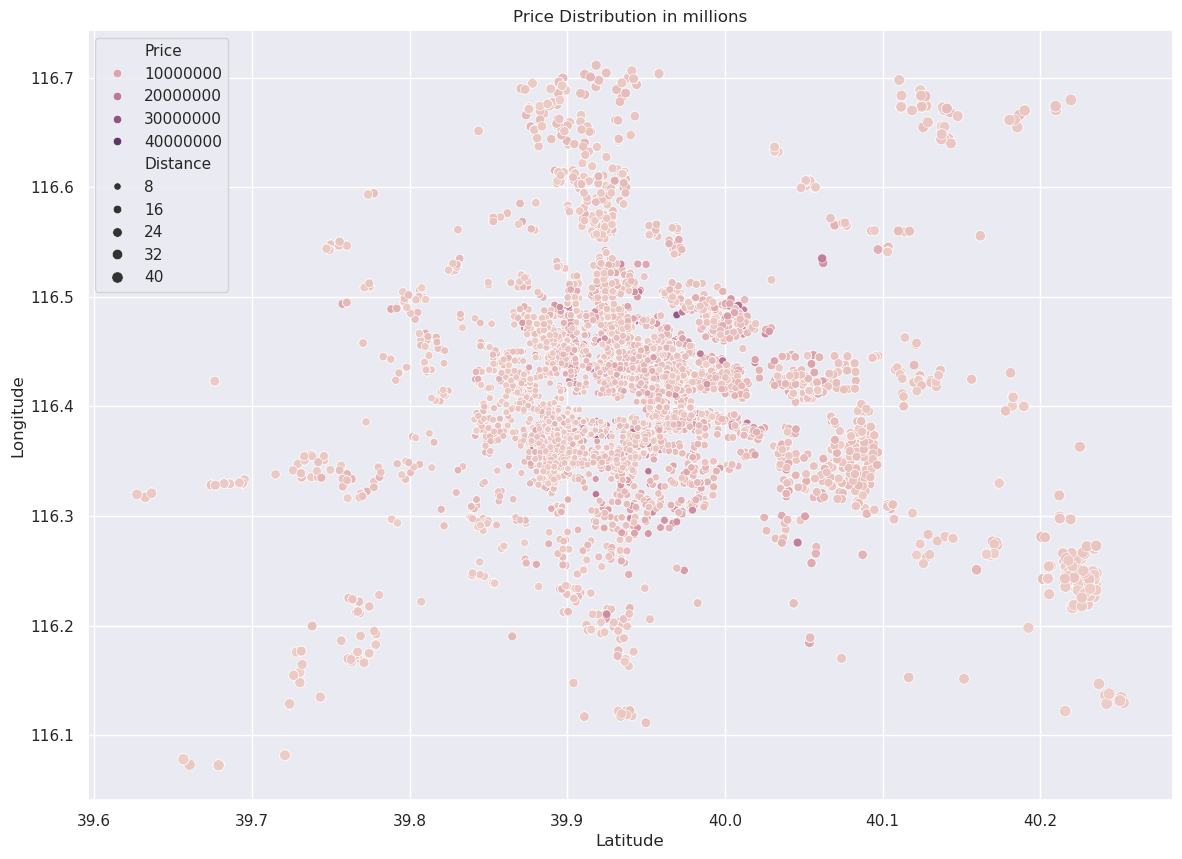

In [28]:
# Heat map of prices according to their location
sns.set(rc = {'figure.figsize':(14,10)})
ax = sns.scatterplot(data = desired_data, x = "Lat", y = "Lng", hue = "Price",size = 'Distance',legend = 'brief')
ax.set(xlabel = "Latitude", ylabel = "Longitude",title = "Price Distribution in millions")

From the above heat map we can see that there is not a true dependence of price and location, therefore we can drop those columns.

In [29]:
desired_data = desired_data.drop('Lat', axis = 1)
desired_data = desired_data.drop('Lng', axis = 1)
desired_data = desired_data.drop('Distance', axis = 1)
desired_data = desired_data.drop('District', axis = 1)

### Dealing with outliers

In [30]:
def Boxplot(df, x, y):
    sns.set(rc = {'figure.figsize':(8,6)})
    ax = sns.boxplot(data = df, x = x, y = y)
    ax.set(xlabel = x, ylabel = y, title = f"Correlation between {x} and {y}")

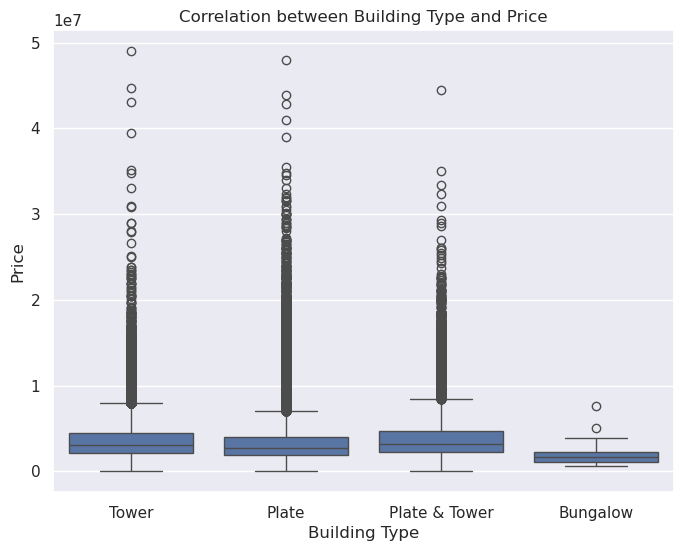

In [31]:
Boxplot(desired_data, 'Building Type', 'Price')

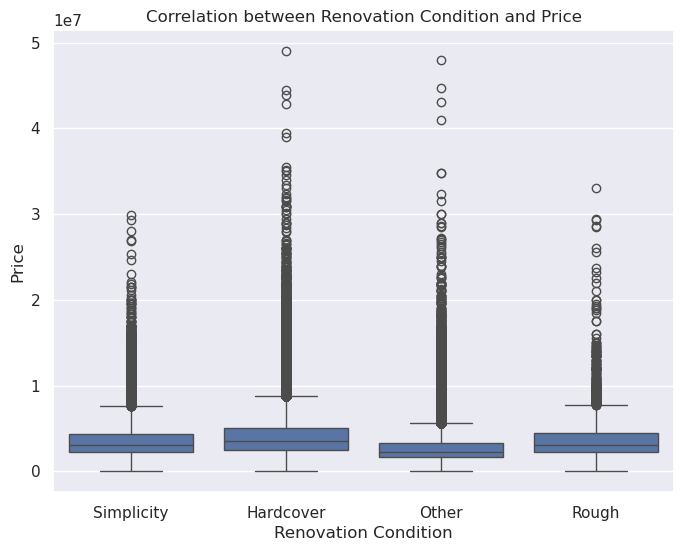

In [32]:
Boxplot(desired_data, 'Renovation Condition', 'Price')

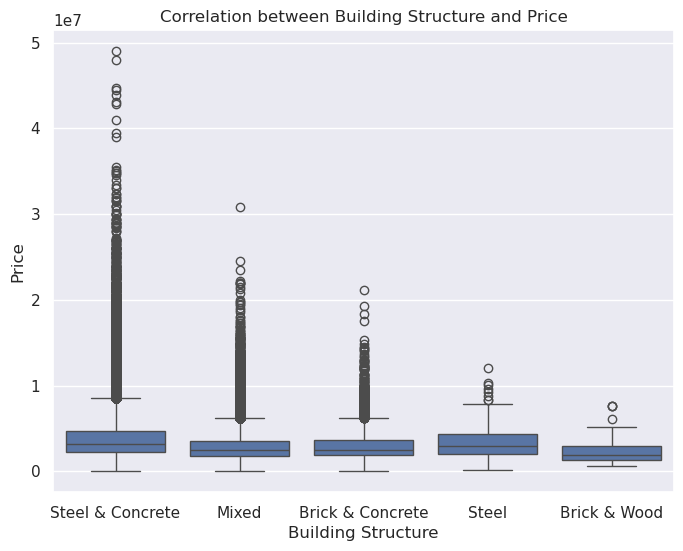

In [33]:
Boxplot(desired_data, 'Building Structure', 'Price')

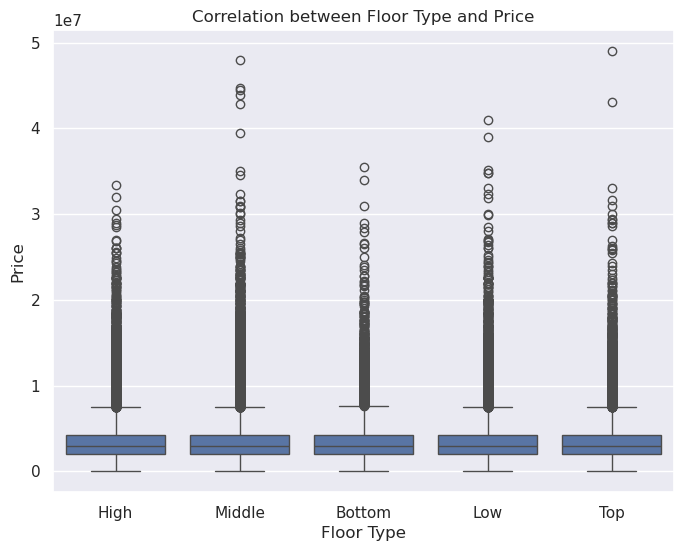

In [34]:
Boxplot(desired_data, 'Floor Type', 'Price')

From the boxplots we can see that we have a lot of outliers, so we are going to count them and if they are a minority of the data set we get rid of them.

In [35]:
lower_limit = None
upper_limit = None

def Outliers(df, column):
    global lower_limit
    global upper_limit
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    outliers_count = df[(df[column] < lower_limit) | (df[column] > upper_limit)].shape[0]
    outliers_rel_freq = round(outliers_count / len(desired_data), 2)

    print(f"The column {column} has {outliers_count} outliers corresponding to {outliers_rel_freq}%.")

Outliers(desired_data, 'Price')

The column Price has 13693 outliers corresponding to 0.05%.


We can see that only 0.05% of the data correspond to outliers, so we are going to drop them.

In [36]:
desired_data = desired_data.loc[(desired_data['Price'] >= lower_limit) & (desired_data['Price'] <= upper_limit)]
Outliers(desired_data, 'Price')

The column Price has 4148 outliers corresponding to 0.02%.


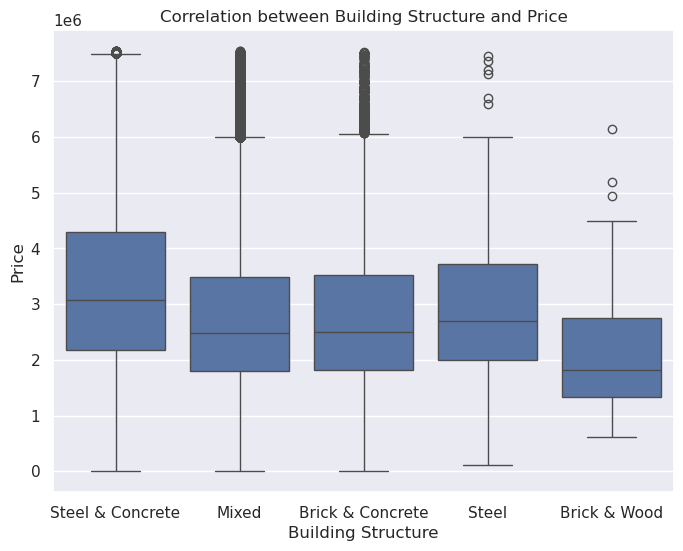

In [37]:
Boxplot(desired_data, 'Building Structure', 'Price')

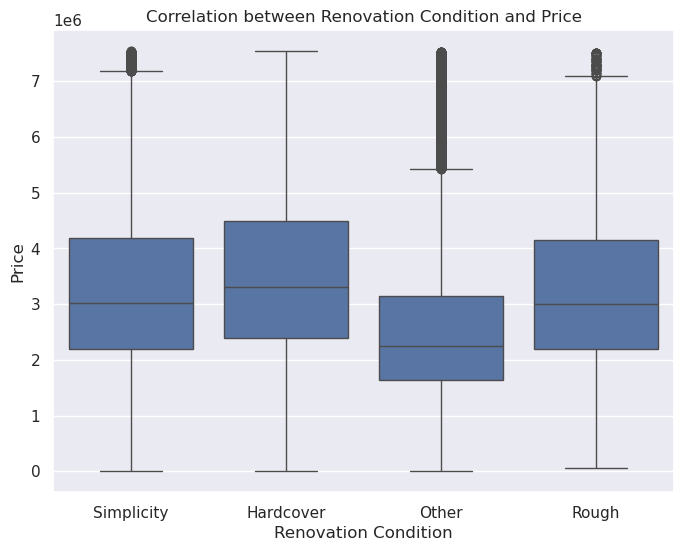

In [38]:
Boxplot(desired_data, 'Renovation Condition', 'Price')

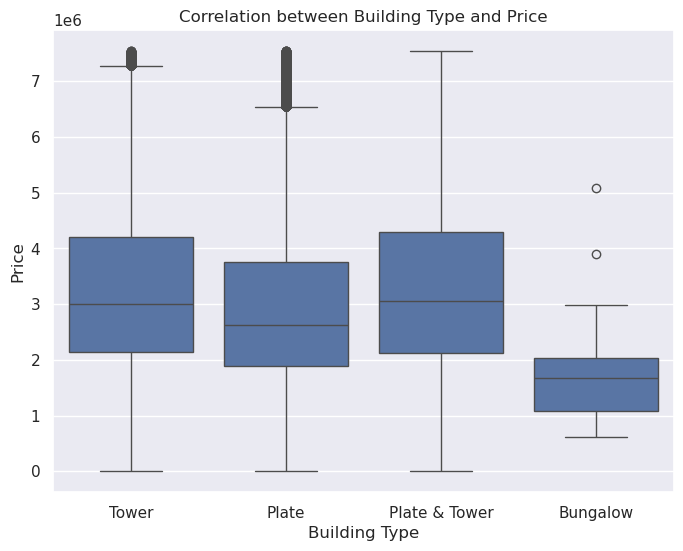

In [39]:
Boxplot(desired_data, 'Building Type', 'Price')

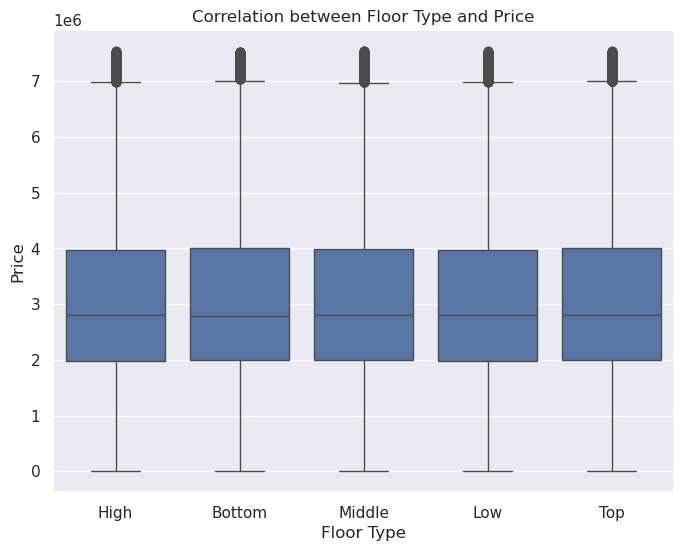

In [40]:
Boxplot(desired_data, 'Floor Type', 'Price')

We can see that Floor Type has an homogeneous behavior with the price, so that column does not contribute to the prediction.

In [41]:
desired_data = desired_data.drop('Floor Type', axis = 1)

# Create dummies variables

In [42]:
desired_data.dtypes

Building Type            object
Renovation Condition     object
Ladder Ratio            float64
Trade Time              float64
Subway                  float64
Community Average       float64
Drawing Room            float64
Construction Time       float64
Five Years Property     float64
Price                   float64
Bathroom                float64
Followers               float64
Square                  float64
Elevator                float64
Kitchen                 float64
Living Room             float64
Building Structure       object
Floor Height            float64
dtype: object

Before creating the dummies variables we are going to convert them to numeric values.

In [43]:
variables = ['Building Type', 'Renovation Condition', 'Building Structure']
prefix = ['Building_Type', 'Renovation_Condition', 'Building_Structure']
final_data = desired_data
dummy_data = pd.DataFrame()

for index in range(3):
    dummy_variables = pd.get_dummies(desired_data[variables[index]], prefix = prefix[index], drop_first = True)
    dummy_variables = dummy_variables.astype(int)
    final_data = pd.concat([final_data, dummy_variables], axis = 1)
    dummy_data = pd.concat([dummy_data, dummy_variables], axis = 1)


final_data = final_data.drop(variables, axis = 1)
final_data.head()

,Ladder Ratio,Trade Time,Subway,Community Average,Drawing Room,Construction Time,Five Years Property,Price,Bathroom,Followers,Square,Elevator,Kitchen,Living Room,Floor Height,Building_Type_Plate,Building_Type_Plate & Tower,Building_Type_Tower,Renovation_Condition_Other,Renovation_Condition_Rough,Renovation_Condition_Simplicity,Building_Structure_Brick & Wood,Building_Structure_Mixed,Building_Structure_Steel,Building_Structure_Steel & Concrete
0,0.217,2016.0,1.0,56021.0,1.0,2005.0,0.0,4150080.00,1.0,106.0,131.00,1.0,1.0,2.0,26.0,0,0,1,0,0,1,0,0,0,1
1,0.667,2016.0,0.0,71539.0,2.0,2004.0,1.0,5750057.68,2.0,126.0,132.38,1.0,1.0,2.0,22.0,0,0,1,0,0,0,0,0,0,1
3,0.273,2016.0,0.0,51238.0,1.0,2008.0,0.0,2975068.00,1.0,138.0,134.00,1.0,1.0,3.0,21.0,0,0,1,1,0,0,0,0,0,1
4,0.333,2016.0,1.0,62588.0,1.0,1960.0,1.0,3920076.00,1.0,286.0,81.00,0.0,1.0,2.0,6.0,1,0,0,0,1,0,0,1,0,0
5,0.333,2016.0,0.0,67738.0,0.0,2005.0,1.0,2756000.00,1.0,57.0,53.00,1.0,1.0,1.0,8.0,1,0,0,0,0,1,0,0,0,1


In [44]:
final_data.columns.tolist()

['Ladder Ratio',
 'Trade Time',
 'Subway',
 'Community Average',
 'Drawing Room',
 'Construction Time',
 'Five Years Property',
 'Price',
 'Bathroom',
 'Followers',
 'Square',
 'Elevator',
 'Kitchen',
 'Living Room',
 'Floor Height',
 'Building_Type_Plate',
 'Building_Type_Plate & Tower',
 'Building_Type_Tower',
 'Renovation_Condition_Other',
 'Renovation_Condition_Rough',
 'Renovation_Condition_Simplicity',
 'Building_Structure_Brick & Wood',
 'Building_Structure_Mixed',
 'Building_Structure_Steel',
 'Building_Structure_Steel & Concrete']

Finally, we verify if there are rows with price equals to zero, if it is the case, we delete the corresponding rows.

In [45]:
(final_data['Price'] == 0).any()

False

### Further data visualization

In [46]:
def scatter_plot(data, *x_col, y_col):
    columns = len(x_col)
    for col in range(columns):
        x_value = data[x_col[col]]
        y_value = data[y_col]
        plt.scatter(x_value, y_value)
        plt.xlabel(x_col[col])
        plt.ylabel(y_col)
        plt.title(f'Scatter Plot - {x_col[col]} vs {y_col}')
        plt.show()

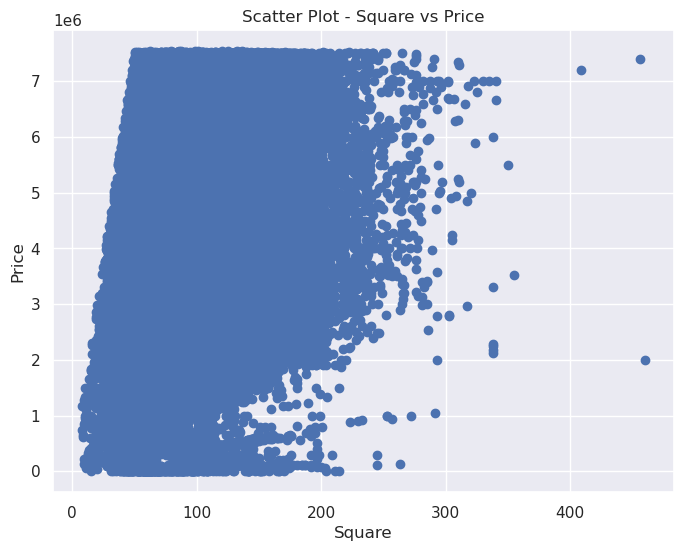

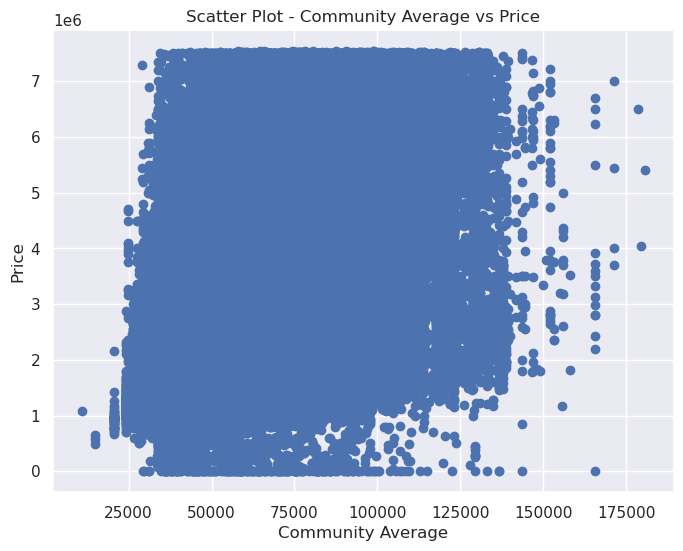

In [47]:
scatter_columns = ['Square', 'Community Average']
prediction_column = 'Price'
scatter_plot(final_data, *scatter_columns, y_col = prediction_column)

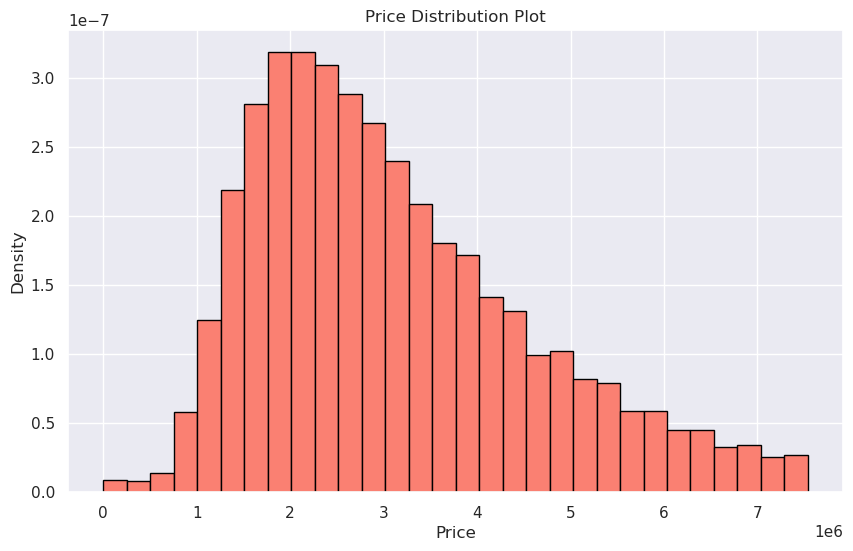

In [48]:
plt.figure(figsize = (10, 6))
plt.hist(final_data['Price'], bins = 30, color = 'salmon', edgecolor = 'black', density = True)
plt.title('Price Distribution Plot')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

### VIF Analysis

In [49]:
predictors = final_data.columns.values.tolist()
predictors.remove('Price')
predictors

['Ladder Ratio',
 'Trade Time',
 'Subway',
 'Community Average',
 'Drawing Room',
 'Construction Time',
 'Five Years Property',
 'Bathroom',
 'Followers',
 'Square',
 'Elevator',
 'Kitchen',
 'Living Room',
 'Floor Height',
 'Building_Type_Plate',
 'Building_Type_Plate & Tower',
 'Building_Type_Tower',
 'Renovation_Condition_Other',
 'Renovation_Condition_Rough',
 'Renovation_Condition_Simplicity',
 'Building_Structure_Brick & Wood',
 'Building_Structure_Mixed',
 'Building_Structure_Steel',
 'Building_Structure_Steel & Concrete']

In [50]:
dummy_variables = dummy_data.columns.tolist()
predictors = [predictor for predictor in predictors if predictor not in dummy_variables]

def VIF(df, columns):
    X = df[columns]
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]
    print(vif_data)

In [51]:
VIF(final_data, predictors)

               Variable           VIF
0          Ladder Ratio      1.000099
1            Trade Time  99042.791206
2                Subway      2.803178
3     Community Average     14.013846
4          Drawing Room     10.401263
5     Construction Time  98626.841534
6   Five Years Property      3.026546
7              Bathroom     19.431650
8             Followers      1.258984
9                Square     33.008238
10             Elevator      3.236876
11              Kitchen    101.278412
12          Living Room     20.944452
13         Floor Height      3.872778


In [52]:
VIF(final_data, dummy_variables)

                              Variable        VIF
0                  Building_Type_Plate  13.532695
1          Building_Type_Plate & Tower   6.349225
2                  Building_Type_Tower   8.579240
3           Renovation_Condition_Other   2.082160
4           Renovation_Condition_Rough   1.047146
5      Renovation_Condition_Simplicity   1.717777
6      Building_Structure_Brick & Wood   1.000954
7             Building_Structure_Mixed   9.243851
8             Building_Structure_Steel   1.011502
9  Building_Structure_Steel & Concrete  15.839817


From the above analysis we are going to drop Trade Time, Construction Time and Kitchen. For the dummy variables the Renovation Condition is the one that has lower VIF, so we are going to keep only that category.

In [53]:
remove = ['Trade Time', 'Kitchen', 'Construction Time']
for r in remove:
    predictors.remove(r)
predictors

['Ladder Ratio',
 'Subway',
 'Community Average',
 'Drawing Room',
 'Five Years Property',
 'Bathroom',
 'Followers',
 'Square',
 'Elevator',
 'Living Room',
 'Floor Height']

In [54]:
dummy_variables = [var for var in dummy_variables if not var.startswith('Building_Type')
                   and not var.startswith('Building_Structure')]
dummy_variables

['Renovation_Condition_Other',
 'Renovation_Condition_Rough',
 'Renovation_Condition_Simplicity']

# Linear Regression

In [55]:
def variable_selection(data, threshold , *predictors, prediction, n):
    predictors = list(predictors)
    # We will use a sample in order to increase the performace:
    sample_size = round(len(data) * threshold)
    sample_data = data.sample(n = sample_size)
    X = sample_data[predictors]
    Y = sample_data[prediction]

    # Select the variables:
    estimator = SVR(kernel = "linear")
    selector = RFE(estimator, n_features_to_select = n, step = 1)
    selector = selector.fit(X,Y)
    # Let's store the data in a dictionary:
    ordered_predictors = {}
    for element in range(len(predictors)):
        ordered_predictors[predictors[element]] = selector.ranking_[element]
    # We order the dictionary by variable relevance:
    ordered_predictors = dict(sorted(ordered_predictors.items(), key = lambda item: item[1]))
    return ordered_predictors

In [56]:
ordered_predictors = variable_selection(final_data, 0.05, *predictors, prediction = 'Price', n = 1)
ordered_predictors

{'Square': 1,
 'Followers': 2,
 'Subway': 3,
 'Elevator': 4,
 'Living Room': 5,
 'Floor Height': 6,
 'Drawing Room': 7,
 'Bathroom': 8,
 'Five Years Property': 9,
 'Ladder Ratio': 10,
 'Community Average': 11}

### Perform the linear regression
We are going to perform several linear regressions increasing the number of variables to maximize the R².

In [57]:
results = {}
for predictor, rank in ordered_predictors.items():
    dummy_variables.append(predictor)
    X = final_data[dummy_variables]
    Y = final_data['Price']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
    lm = LinearRegression()
    lm.fit(X_train, Y_train)
    score = lm.score(X_train, Y_train)
    results[rank] = score
print(results)

{1: 0.2749381935675954, 2: 0.30030500146696104, 3: 0.330977162877908, 4: 0.3430371395994929, 5: 0.35539662297855157, 6: 0.3555329424390159, 7: 0.3570684679009539, 8: 0.35709708059022904, 9: 0.35758249381555696, 10: 0.3577728005907831, 11: 0.6021874748337298}


We can see that the model tha maximizes the R² statistic is the model that incorporates all the variables.

In [58]:
def statisitcs(Y_test, Y_pred, predictors):
    RSS = sum((Y_test - Y_pred) ** 2)
    RSE = np.sqrt(RSS / (len(Y_test) - len(predictors) - 1))
    Y_mean = np.mean(Y_test)
    error = (RSE / Y_mean) * 100
    TSS = sum((Y_test - Y_mean) ** 2)
    r2 = 1 - (RSS / TSS)
    statistics = {
        'Statistic': ['Residual Squared Sum (RSS)', 'Total Squared Sum (TSS)', 'Residual Standard Error (RSE)',
                     'Error', 'R²'],
        'Value': [RSS, TSS, RSE, error, r2]
    }
    df_statistics = pd.DataFrame(statistics)
    return df_statistics

In [59]:
Y_pred = lm.predict(X_test)
performance = statisitcs(Y_test = Y_test, Y_pred = Y_pred, predictors = dummy_variables)
print(performance)

                       Statistic         Value
0     Residual Squared Sum (RSS)  1.839774e+25
1        Total Squared Sum (TSS)  1.171473e+17
2  Residual Standard Error (RSE)  1.861888e+10
3                          Error  5.966674e+05
4                             R² -1.570480e+08


Based in these statistics we conclude tha a linear regression is not the best model to predict housing prices in Beijing. So we are going to use another machine learning model.

# Support Vector Machine (SVM)
We are going to choose multiple kernels (except linear) and keep the best using cross validation. Also we are going to scale the data for better performance.

In [60]:
# Scale the data for better performance
def Scaler(X_train, X_test, scaler):
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [61]:
def SVM(X_train, X_test, Y_train, Y_test, kernel):
    svm_model = SVR(kernel = kernel, C = 1.0)
    svm_model.fit(X_train, Y_train)
    Y_pred = svm_model.predict(X_test)
    performance = statisitcs(Y_test = Y_test, Y_pred = Y_pred, predictors = dummy_variables)
    print(performance)

In [62]:
scale_types = ['minmax', 'robust']
kernel_types = ['poly', 'rbf', 'sigmoid']

# Take a sample of the data
subset_size = round(len(final_data) * 0.1)

# Random selection
subset_indices = random.sample(range(len(X_train)), subset_size)
X_train_subset = X_train.iloc[subset_indices]
Y_train_subset = Y_train.iloc[subset_indices]

X_train_sub, X_test_sub, Y_train_sub, Y_test_sub = train_test_split(X_train_subset, Y_train_subset, 
                                                                    test_size = 0.2, random_state = 42)

for scale_type in scale_types:
    print(f"The scale used is: {scale_type}")
    
    if scale_type == 'minmax':
        scaler = MinMaxScaler()
    elif scale_type == 'robust':
        scaler = RobustScaler()
        
    X_train_scaled, X_test_scaled = Scaler(X_train_sub, X_test_sub, scaler)
    
    for kernel in kernel_types:
        print(f"The kernel used is: {kernel}")
        SVM(X_train_scaled, X_test_scaled, Y_train_sub, Y_test_sub, kernel)

The scale used is: minmax
The kernel used is: poly
                       Statistic         Value
0     Residual Squared Sum (RSS)  1.204454e+16
1        Total Squared Sum (TSS)  1.157301e+16
2  Residual Standard Error (RSE)  1.508353e+06
3                          Error  4.826852e+01
4                             R² -4.074372e-02
The kernel used is: rbf
                       Statistic         Value
0     Residual Squared Sum (RSS)  1.207402e+16
1        Total Squared Sum (TSS)  1.157301e+16
2  Residual Standard Error (RSE)  1.510198e+06
3                          Error  4.832757e+01
4                             R² -4.329154e-02
The kernel used is: sigmoid
                       Statistic         Value
0     Residual Squared Sum (RSS)  1.207507e+16
1        Total Squared Sum (TSS)  1.157301e+16
2  Residual Standard Error (RSE)  1.510264e+06
3                          Error  4.832966e+01
4                             R² -4.338198e-02
The scale used is: robust
The kernel used is: poly


From the above statistics we can see that also a SVM model is not optimal for our problem.
# Decision Tree

In [63]:
decision_tree_model = DecisionTreeRegressor(random_state = 42)

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 1, 2, 3]
}

# Use a sample to find best parameters
grid_search = GridSearchCV(decision_tree_model, param_grid, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1) # n_jobs = -1 to use all cores of the proccessor.
grid_search.fit(X_train, Y_train)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Y_pred = best_model.predict(X_test)
performance = statisitcs(Y_test = Y_test, Y_pred = Y_pred, predictors = dummy_variables)
print(performance)

Best parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
                       Statistic         Value
0     Residual Squared Sum (RSS)  3.560098e+16
1        Total Squared Sum (TSS)  1.171473e+17
2  Residual Standard Error (RSE)  8.190348e+05
3                          Error  2.624708e+01
4                             R²  6.961006e-01


From the above statistics we can see that a decision tree is the best model so far, however, it still has a significant error, our model has a 26.24% of error. So the next model we are going to use is going to be a Random Forest.
# Random Forest

In [64]:
# Best parameter for the decision tree
best_params = {
    'max_depth': 10,
    'max_features': None,
    'min_samples_leaf': 4,
    'min_samples_split': 10
}

random_forest_model = RandomForestRegressor(
    n_estimators = 100, 
    **best_params  
)
random_forest_model.fit(X_train, Y_train)
Y_pred = random_forest_model.predict(X_test)

performance = statisitcs(Y_test = Y_test, Y_pred = Y_pred, predictors = dummy_variables)
print(performance)

                       Statistic         Value
0     Residual Squared Sum (RSS)  3.333873e+16
1        Total Squared Sum (TSS)  1.171473e+17
2  Residual Standard Error (RSE)  7.925851e+05
3                          Error  2.539947e+01
4                             R²  7.154118e-01


We can see that the improvements were small, so we are going to stick with the Random Forest model.